# Diffusion of Lithium species in the electrolyte 

This model is commonly called the Single Particle Model with electrolyte (SPMe).

The equation for diffusion of the Lithium species in the electrolyte is governed by Fick's 2nd law of diffusion

$$
\frac{dc_e}{dt} = D \frac{d^2 c_e}{dx^2}
$$

which says that the change in Lithium concentration in the electrolyte at a given time $t$ and spatial position $x$, $c_e(t, x)$, is dependent on the concentration gradient of $Li^+$ at that point in time and space.

To solve this, discretization is required, and the concentration at each $x$-value can be calculated using the [second symmetric derivative](https://en.wikipedia.org/wiki/Symmetric_derivative#The_second_symmetric_derivative):

$$
\frac{d^2 c_e(x)}{dx^2} = \frac{c_e(x+1)-2c_e(x) + c_e(x-1)}{\Delta x^2}
$$

While the time evolution would be described by

$$
c_{e, i}(t+1) = c_{e, i}(t) + D \frac{\Delta t}{\Delta x^2} \left( c_e(x+1, t)-2c_e(x, t) + c_e(x-1, t) \right)
$$

The current flow is modeled by generation and depletion of $Li^+$ at each boundary, commonly called Neumann boundary conditions (flux-based). This gives the boundary conditions:

$$
\frac{dc_e(x=0)}{dt} = D_e\frac{d^2c_e}{dx^2} -\frac{I(t)}{nFV_e}
$$

$$
\frac{dc_e(x=L)}{dt} = D_e\frac{d^2c_e}{dx^2} + \frac{I(t)}{nFV_e}
$$

which describes that the change in Lithium at the electrolyte boundary has to be equal to the change due to diffusion plus the $Li^+$ generation and consumption at $x=0$ and $x=L$. Here $x$ is the dimension stretching from one electrode to the other. $x=0$ is at the negative electrode-electrolyte interface, and $x=L$ is at the positive electrode-electrolyte interface. This means that L can be considered the separator thickness in a conventional LIB. $V_e$ is the volume of the x-discretized element of the electrolyte at each boundary.

## Using the electrolyte concentration in the model

With the model now capable of electrolyte diffusion simulation; the most reasonable way to use it in the model is to make the exchange current density of the Butler Volmer kinetics.

The exchange current density is often written as the reference reaction rate $m_{ref}$, the activation constant $E_r$, the temperature $T$, the ideal gas constant $R$, the surface particle concentration $c_{s,surf}$ (which is this case is equal to the bulk), the maximum particle concentration $c_{s,max}$ and the electrolyte concentration $c_e$:
$$
m_{ref} \cdot e^{\frac{E_r}{R} * \left( \frac{1}{298.15} - \frac{1}{T} \right)} \cdot \sqrt{c_e} \cdot \sqrt{c_{s,surf}} \cdot \sqrt{c_{s,max}-c_{s,surf}}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from dataclasses import dataclass


In [ ]:

@dataclass
class ParameterSet:
    """Parameters of model 04"""
    # Max lithium concentrations in electrodes
    c_max_n: float = 34684 # mol/m³
    c_max_p: float = 50060 # mol/m³
    # Initial parameters
    c_init_n: float = 1000  # mol/m³
    c_init_p: float = 49000 # mol/m³
    c_init_e: float = 1000  # mol/m³ LiPF6 is 1M in most organic electrolytes

    # Geometry
    # Radiuses was calculated from c_max and theoretical capacity of 3.2Ah by r = cbrt(3/(4*pi) * 3.2Ah/(F*C_max))
    r_n: float = 0.02009/2 # m
    r_p: float = 0.01778/2 # m
    # Size
    L = 200e-6 # m, current collector to current collector thickness
    A = 1.2*0.06*500000 # m^2, area of current collector

    # Constants
    n: float = 1 # Unitless, number of charges in a reaction. Li+ + e- -> Li has 1.
    F: float = 96485.3321233100184 # C/mol (=As/mol), SI
    R: float = 8.31446261815324 # J/(K*mol), SI
    T: float = 298.15 # Kelvin, equaling 25 degrees

    # Kinetic parameters
    m_ref: float = 6.48e-7 # (A/m^2)(m^3/mol)^1.5 reaction rate constant
    E_r: float = 35000 # Activation of some sort?

    # Electrolyte
    D_e: float = 1e-11 # Diffusion rate of Lithium ions in the electrolyte

    # Discretization
    Nx: int = 50 # Number of x-discretized points
    dx: float = L/Nx # m, x-discretized spacing

    # Open circuit potential of lithium concentration
    def U_n(self, c):
        x = c/self.c_max_n # Converting to stoichiometry
        p = np.array([ 1.20912055e+00,  5.62297420e+01, -1.11020020e-01, -2.53458213e-01, 4.92581391e+01,  1.22046522e-02,  4.73538620e-02,  1.79631246e+01, 1.75283209e-01,  1.88038929e-02,  3.03255334e+01,  4.66328034e-01])
        return (
                p[0] * np.exp(-p[1] * x)
                + p[2]
                - p[3] * np.tanh(p[4] * (x - p[5]))
                - p[6] * np.tanh(p[7] * (x - p[8]))
                - p[9] * np.tanh(p[10] * (x - p[11]))
            )
    
    def U_p(self, c):
        x = c/self.c_max_p # Converting to stoichiometry
        p = np.array([ 0.74041974,  4.39107343,  0.03434767, 18.16841489,  0.53463176, 17.68283504, 14.59709162,  0.28835348, 17.58474971, 14.69911523,  0.28845641])
        return (
                -p[0] * x
                + p[1]
                - p[2] * np.tanh(p[3] * (x - p[4]))
                - p[5] * np.tanh(p[6] * (x - p[7]))
                + p[8] * np.tanh(p[9] * (x - p[10]))
            )


@dataclass
class CurrentFunction:
    tp: np.ndarray # time array, monotonically increasing
    ip: np.ndarray # current array
    def __init__(self, t, i):
        self.tp = t
        self.ip = i

    def I(self, t):
        return np.interp(t, self.tp, self.ip)


class Model():
    def __init__(self, parameters: ParameterSet, current_function: CurrentFunction):
        self.p = parameters
        self.cf = current_function

    def U_batt(self, c_p_s, c_n_s, eta_p, eta_n):
        return self.p.U_p(c_p_s) - self.p.U_n(c_n_s) + eta_p + eta_n

    def eta(self, i, i0):
        """
        Butler volmer overpotential assuming symmetry
        i is current density
        i0 is exchange current density
        returns BV overpotential
        """
        eta = (2*self.p.R*self.p.T)/(self.p.n * self.p.F) * np.arcsinh(i/(2*i0))
        return eta

    def i0(self, c_e, c_s_surf, c_s_max):
        arrhenius = np.exp(self.p.E_r / self.p.R * (1/298.15-1/self.p.T))

        i0 = self.p.m_ref * arrhenius * np.sqrt(c_e) * np.sqrt(c_s_surf) * np.sqrt(c_s_max - c_s_surf)
        return i0

    def Vsphere(self, r):
        """Volume of a sphere given the radius"""
        return 4/3 * np.pi * r**3

    def dcdt(self, t, y, i, r):
        """
        t: Time
        y: state
        i: Electrode negative, n or positive p
        r: Radius of electrode particle
        n: Number of electrons in process
        F: Faraday constant in Coulomb/mol (=As/mol)
        """
        c_init = y

        if i == 'p':
            a = -1
        elif i == 'n':
            a = 1
        else:
            raise ValueError
        
        return a * self.cf.I(t) / (self.p.n * self.p.F * self.Vsphere(r))
    
    def dc_edt(self, t, c):
        # Change of concentration in electrolyte with regards to time
        dc = np.zeros_like(c)

        # Interior points
        dc[1:-1] = self.p.D_e * (c[2:] - 2*c[1:-1] + c[:-2])/self.p.dx**2

        # Flux, symmetrical:
        J = self.cf.I(t)/(self.p.n*self.p.F*self.p.A*self.p.dx)

        # Neumann boundary conditions as ghost points
        c_n = c[1] + self.p.dx *(-J)/self.p.D_e
        c_p = c[-2] + self.p.dx *(J)/self.p.D_e

        dc[0] = self.p.D_e * (c[1]-2*c[0]+c_n)/ (self.p.dx**2)
        dc[-1] = self.p.D_e * (c_p -2*c[-1]+c[-2])/ (self.p.dx**2)
        return dc
    
    def solve(self, t_eval = None):
        if type(t_eval) == type(None):
            t_eval = np.linspace(np.min(self.cf.tp), np.max(self.cf.tp), 10000)
        # t_eval = np.linspace(0, 6*3600, 10000)
        t_span = (min(t_eval), max(t_eval))

        n_y0 = [self.p.c_init_n]
        n_args = ('n', self.p.r_n)
        c_n_s = solve_ivp(self.dcdt, t_span, n_y0, t_eval=t_eval, args = n_args)

        p_y0 = [self.p.c_init_p]
        p_args = ('p', self.p.r_p)
        c_p_s = solve_ivp(self.dcdt, t_span, p_y0, t_eval=t_eval, args = p_args)

        c_e_y0 = np.ones(self.p.Nx) * self.p.c_init_e

        # Apparently, the problem is "stiff" and BDF algo works better for this.
        c_e = solve_ivp(self.dc_edt, t_span, c_e_y0, t_eval = t_eval, method="BDF")


        eta_p = self.eta(self.cf.I(t_eval), self.i0(c_e.y[0],c_p_s.y, self.p.c_max_p))
        eta_n = self.eta(self.cf.I(t_eval), self.i0(c_e.y[-1],c_n_s.y, self.p.c_max_n))

        U = self.U_batt(c_p_s.y, c_n_s.y, eta_p, eta_n)
        return t_eval, U, c_e

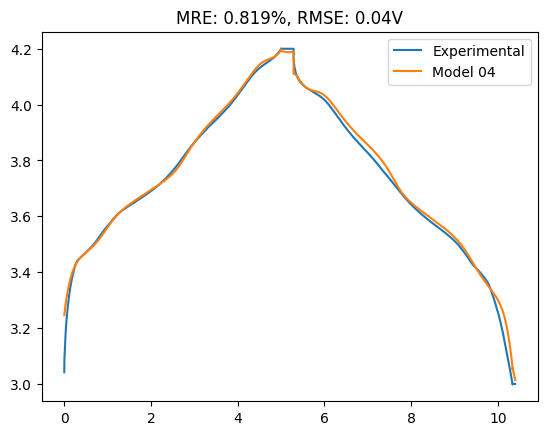

In [138]:
# Comparing model to reference cell at BoL
exp = np.genfromtxt('MJ1_01_01_C5.csv', delimiter=",", skip_header=1).T
exp[1] = exp[1]-exp[1][0]   # Convert UNIX Epoch to experiment time
unique_idx = np.unique(exp[1], return_index=True)[1] # Time is only second-resolved, so remove any time-duplicates
exp_t, exp_u, exp_i = exp[1:4, unique_idx] # Pick only the interesting columns, and then only the unique rows

def mean_relative_error(actual, predicted):
    return np.mean(np.abs(actual - predicted) / predicted)
def root_mean_square_error(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

p = ParameterSet()
c = CurrentFunction(exp_t, exp_i)
p.r_n, p.r_p, p.c_init_n, p.c_init_p, p.m_ref = [0.02009/2*1, 0.01778/2*1.05, 750, 48000, 10e-7]
m = Model(p, c)

t, U, c_e = m.solve(t_eval=exp_t)

plt.plot(exp_t/3600, exp_u, label="Experimental")
plt.plot(t/3600, U[0], label = "Model 04")
plt.title(f"MRE: {mean_relative_error(U, exp_u):.3%}, RMSE: {root_mean_square_error(U, exp_u):.2f}V")
plt.legend()

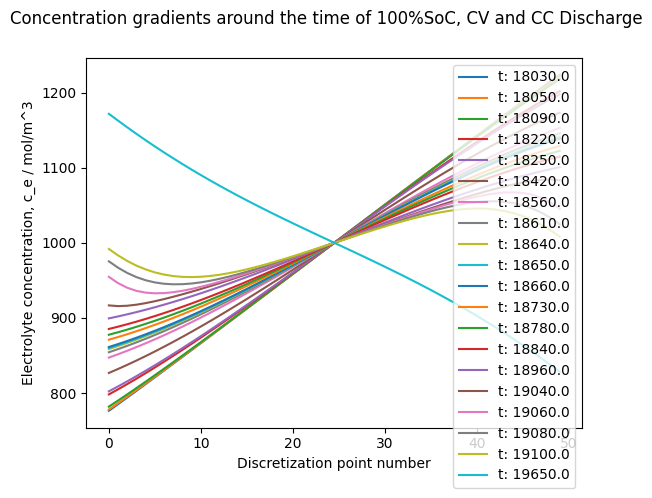

In [129]:
fig, ax = plt.subplots()
for t_step, c_e_t in zip(c_e.t, c_e.y.T):
    if t_step < 18030:
        continue
    elif t_step > 19650:
        continue
    if t_step%10 == 0:
        plt.plot(np.array([x for x in range(p.Nx)]), c_e_t, label=f"t: {t_step}")
    # if t_step>3600:
    #     break
fig.suptitle("Concentration gradients around the time of 100%SoC, CV and CC Discharge")
ax.set_xlabel("Discretization point number")
ax.set_ylabel("Electrolyte concentration, c_e / mol/m^3")
plt.legend()

/tmp/ipykernel_6642/340806091.py:94: RuntimeWarning: invalid value encountered in sqrt
  i0 = self.p.m_ref * arrhenius * np.sqrt(c_e) * np.sqrt(c_s_surf) * np.sqrt(c_s_max - c_s_surf)
/tmp/ipykernel_6642/340806091.py:94: RuntimeWarning: invalid value encountered in sqrt
  i0 = self.p.m_ref * arrhenius * np.sqrt(c_e) * np.sqrt(c_s_surf) * np.sqrt(c_s_max - c_s_surf)


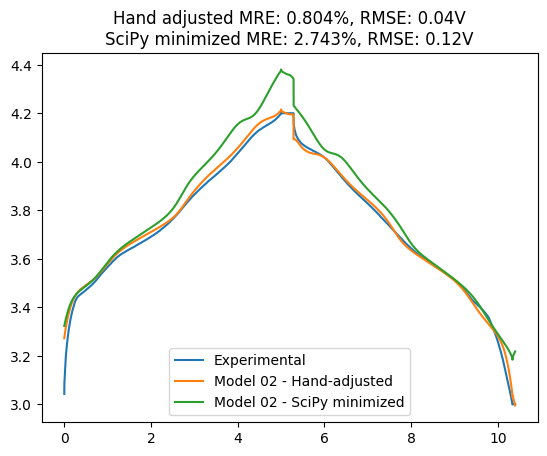

In [134]:
# Refine parameters using SciPy minimize.
from scipy.optimize import minimize

# It only makes sense to refine radiuses (thus total capacity) and initial concentrations.
def loss(x):
    p = ParameterSet()
    p.r_n, p.r_p, p.c_init_n, p.c_init_p = x
    m = Model(p, c)
    t, U, c_e= m.solve(t_eval=exp_t)
    return root_mean_square_error(U, exp_u)

x0 = [0.02009/2, 0.01778/2, 1000, 49000]
res = minimize(loss, x0)

p = ParameterSet()

# Experimental reference
plt.plot(exp_t/3600, exp_u, label="Experimental")

# Plot model with hand-adjusted parameters
x0_hand = [0.02009/2*1, 0.01778/2*1.05, 750, 48000]
p.r_n, p.r_p, p.c_init_n, p.c_init_p = x0_hand
m = Model(p, c)
t, U, c_e = m.solve(t_eval=exp_t)
plt.plot(t/3600, U[0], label="Model 02 - Hand-adjusted")

# Plot model with SciPy minimize adjusted parameters
p.r_n, p.r_p, p.c_init_n, p.c_init_p = res.x
m = Model(p, c)
t_res, U_res, c_e_res = m.solve(t_eval=exp_t)
plt.plot(t_res/3600, U_res[0], label="Model 02 - SciPy minimized")

plt.title(f"Hand adjusted MRE: {mean_relative_error(U, exp_u):.3%}, RMSE: {root_mean_square_error(U, exp_u):.2f}V\nSciPy minimized MRE: {mean_relative_error(U_res, exp_u):.3%}, RMSE: {root_mean_square_error(U_res, exp_u):.2f}V")
plt.legend()


# Conclusion
Incorporating electrolyte diffusion yields a nice adjustment to the Butler-Volmer kinetics.